In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

import sys
import os.path as osp

SRC_SUBDIR = '../src/'
SRC_SUBDIR = osp.abspath(SRC_SUBDIR)
if SRC_SUBDIR not in sys.path:
    sys.path.insert(1, SRC_SUBDIR)
    
from load_data import LoadData
from clean_data import CleanData

In [2]:
data_location = '/raw/'
export_date = '2025-03-01'
load_data = LoadData(data_location, export_date)

### response : mood

In [3]:
mood_data = load_data.load_mood_data()
mood_data.head()

,dt,mood_type,value,updated_time
0,"Sat, 6 May 2023 14:00:58",feeling,4,"Sat, 6 May 2023 14:00:58"
1,"Sun, 11 Feb 2024 04:06:37",satisfaction,4,"Sun, 11 Feb 2024 04:06:37"
2,"Wed, 2 Nov 2022 09:04:11",motivation,3,"Wed, 2 Nov 2022 09:04:11"
3,"Wed, 12 Jul 2023 19:02:37",feeling,3,"Wed, 12 Jul 2023 19:02:37"
4,"Sat, 1 Mar 2025 13:39:47",motivation,2,"Sat, 1 Mar 2025 13:39:47"


In [4]:
clean_data = CleanData()
mood_df = clean_data.clean_mood_data(mood_data)
avg_feelings_df = mood_df[['Record_Date','average_feeling']]
avg_feelings_df = avg_feelings_df.rename(columns={'average_feeling':'value'})
avg_feelings_df.head()

,Record_Date,value
0,2022-10-26,3.000000
1,2022-10-27,2.833333
2,2022-10-28,3.125000
3,2022-10-29,3.375000
4,2022-10-30,3.571429


### explanatory variables: self-care activities

In [5]:
exvar_data = load_data.load_activity_data()
exvar_df = clean_data.clean_activity_data(exvar_data)

completed_variables_df = exvar_df.query("bullet_status == 1.0").drop(['bullet_status'],axis=1)
completed_variables_df = completed_variables_df.rename(columns={'text':'variable'})
completed_variables_df.head()

,Record_Date,variable
4,2023-09-05,Read for fun
5,2024-07-16,Yoga
6,2024-02-11,Start a load of laundry
10,2024-12-25,Just be
12,2024-05-15,Start a load of laundry


In [6]:
ex_variables = [
    'Eat breakfast',
    'Eat lunch',
    'Eat Dinner',
    'Meditation',
    'Mindfulness Walk',
    'Read for fun',
    'Take a shower',
    'Yoga',
    'Gratitude Jar',
]

In [7]:
ex_variable_names = {}
for var in ex_variables:
    ex_variable_names[var] = string.capwords(var)

In [8]:
ex_variable_names

{'Eat breakfast': 'Eat Breakfast',
 'Eat lunch': 'Eat Lunch',
 'Eat Dinner': 'Eat Dinner',
 'Meditation': 'Meditation',
 'Mindfulness Walk': 'Mindfulness Walk',
 'Read for fun': 'Read For Fun',
 'Take a shower': 'Take A Shower',
 'Yoga': 'Yoga',
 'Gratitude Jar': 'Gratitude Jar'}

In [9]:
completed_var_limit_df = completed_variables_df[completed_variables_df['variable'].isin(ex_variables)]
completed_encoded_exvar_df = pd.get_dummies(completed_var_limit_df.variable).join(completed_var_limit_df).drop('variable',axis=1)
completed_encoded_exvar_df = completed_encoded_exvar_df.rename(columns=ex_variable_names)
completed_encoded_exvar_df.head()

,Eat Dinner,Eat Breakfast,Eat Lunch,Gratitude Jar,Meditation,Mindfulness Walk,Read For Fun,Take A Shower,Yoga,Record_Date
4,False,False,False,False,False,False,True,False,False,2023-09-05
5,False,False,False,False,False,False,False,False,True,2024-07-16
13,False,False,True,False,False,False,False,False,False,2024-10-17
15,False,True,False,False,False,False,False,False,False,2023-08-19
16,True,False,False,False,False,False,False,False,False,2024-11-05


In [10]:
exvar_encoded_df = completed_encoded_exvar_df.groupby('Record_Date').any()
exvar_encoded_df.head()

,Eat Dinner,Eat Breakfast,Eat Lunch,Gratitude Jar,Meditation,Mindfulness Walk,Read For Fun,Take A Shower,Yoga
Record_Date,,,,,,,,,
2022-10-27,False,False,False,True,False,False,False,False,False
2022-11-01,False,False,False,False,True,False,False,False,False
2022-11-02,False,False,False,False,True,False,False,False,False
2022-11-03,False,False,False,False,True,False,False,False,False
2022-11-04,False,False,False,False,True,False,False,False,False


In [11]:
for col in ex_variable_names.values():
    exvar_encoded_df[col] = exvar_encoded_df[col].astype(int)
exvar_encoded_df.head()    

,Eat Dinner,Eat Breakfast,Eat Lunch,Gratitude Jar,Meditation,Mindfulness Walk,Read For Fun,Take A Shower,Yoga
Record_Date,,,,,,,,,
2022-10-27,0,0,0,1,0,0,0,0,0
2022-11-01,0,0,0,0,1,0,0,0,0
2022-11-02,0,0,0,0,1,0,0,0,0
2022-11-03,0,0,0,0,1,0,0,0,0
2022-11-04,0,0,0,0,1,0,0,0,0


In [12]:
all_days = pd.date_range(start=exvar_encoded_df.index.min(), end=exvar_encoded_df.index.max(), freq='D')
exvar_encoded_df = exvar_encoded_df.reindex(all_days)
exvar_encoded_df.head()

,Eat Dinner,Eat Breakfast,Eat Lunch,Gratitude Jar,Meditation,Mindfulness Walk,Read For Fun,Take A Shower,Yoga
2022-10-27,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-10-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
exvar_encoded_df.index.name = 'Record_Date'
exvar_encoded_df = exvar_encoded_df.reset_index()
exvar_encoded_df.head()

,Record_Date,Eat Dinner,Eat Breakfast,Eat Lunch,Gratitude Jar,Meditation,Mindfulness Walk,Read For Fun,Take A Shower,Yoga
0,2022-10-27,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2022-10-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1 day lag and 3 day lag

In [14]:
lagged_1day_features = []
for col in ex_variable_names.values():
    col_name = f'{col}_lag1'
    exvar_encoded_df[col_name] = exvar_encoded_df[col].shift(1)
    lagged_1day_features.append(col_name)

lagged_3day_features = []
for col in ex_variable_names.values():
    col_name = f'{col}_lag3'
    exvar_encoded_df[col_name] = exvar_encoded_df[col].shift(3)
    lagged_1day_features.append(col_name)

lagged_features = lagged_1day_features + lagged_3day_features

In [15]:
exvar_lagged_df = exvar_encoded_df[lagged_features+['Record_Date']]

In [16]:
df = pd.merge(avg_feelings_df, exvar_lagged_df, on='Record_Date', how='inner')

In [17]:
fill_values = {}
for col in lagged_features:
    fill_values[col] = 0
    
df = df.fillna(value=fill_values)
df = df.dropna(subset=['value'])
# assuming that if I'm missing records then I just didn't do that activity

In [18]:
df.head()

,Record_Date,value,Eat Breakfast_lag1,Eat Lunch_lag1,Eat Dinner_lag1,Meditation_lag1,Mindfulness Walk_lag1,Read For Fun_lag1,Take A Shower_lag1,Yoga_lag1,Gratitude Jar_lag1,Eat Breakfast_lag3,Eat Lunch_lag3,Eat Dinner_lag3,Meditation_lag3,Mindfulness Walk_lag3,Read For Fun_lag3,Take A Shower_lag3,Yoga_lag3,Gratitude Jar_lag3
0,2022-10-27,2.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-10-28,3.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-10-29,3.375000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-10-30,3.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2022-10-31,3.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# lets examine mood on day after yoga vs no yoga days
df_box = df[['value', 'Yoga_lag1', 'Yoga_lag3']].dropna()

#map to labels for nicer x-axis
df_box['Yoga_Yesterday'] = df_box['Yoga_lag1'].map({0: 'No Yoga', 1: 'Yoga'})
df_box['Yoga_3_Days_Ago'] = df_box['Yoga_lag3'].map({0: 'No Yoga', 1: 'Yoga'})

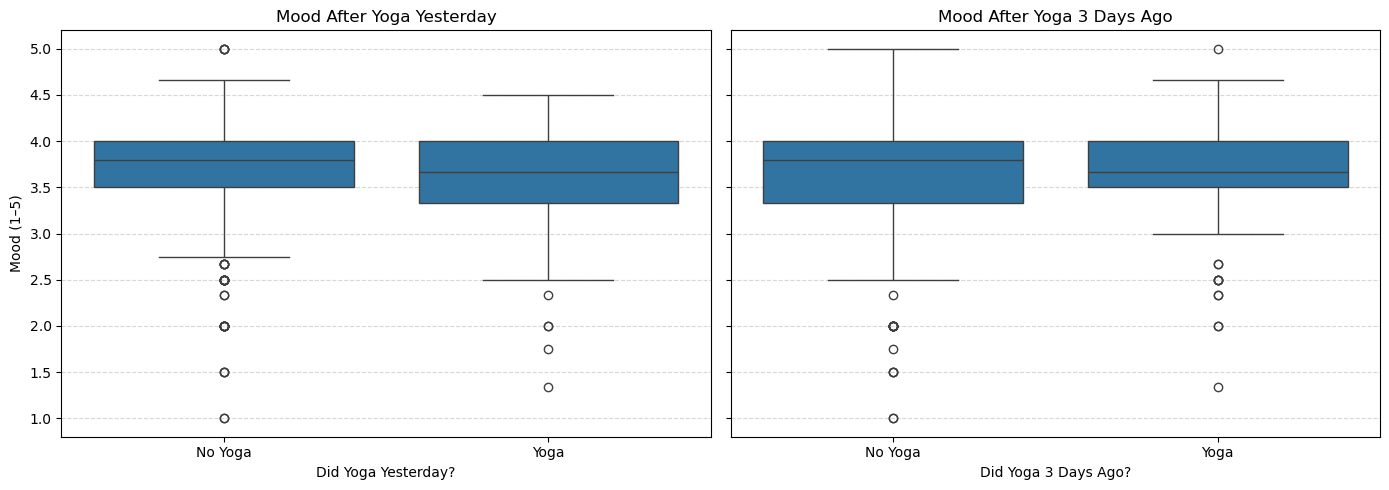

In [20]:
# Set up the subplot grid: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# First boxplot: Mood vs Yoga_Yesterday
sns.boxplot(ax=axes[0], x='Yoga_Yesterday', y='value', data=df_box)
axes[0].set_title("Mood After Yoga Yesterday")
axes[0].set_xlabel("Did Yoga Yesterday?")
axes[0].set_ylabel("Mood (1–5)")
axes[0].grid(True, axis='y', linestyle='--', alpha=0.5)

# Second boxplot: Mood vs Yoga_3_Days_Ago
sns.boxplot(ax=axes[1], x='Yoga_3_Days_Ago', y='value', data=df_box)
axes[1].set_title("Mood After Yoga 3 Days Ago")
axes[1].set_xlabel("Did Yoga 3 Days Ago?")
axes[1].set_ylabel("")  # No y-label to avoid redundancy
axes[1].grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

* middle 50% of mood values (from Q1 to Q3) is more consistent after doing yoga
* while the median mood isn’t higher, yoga days seem to produce more stable mood outcomes
* lower median mood could be due to confounding variables (e.g. doing yoga BECAUSE I had been feeling down)

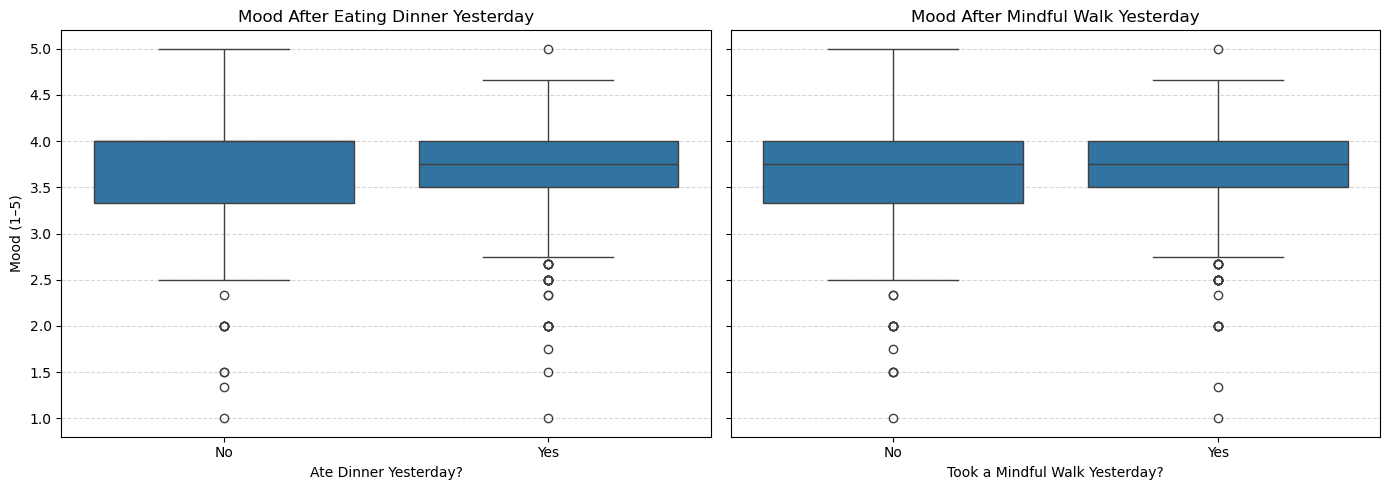

In [21]:
df_box = df[['value', 'Mindfulness Walk_lag1', 'Eat Dinner_lag1']].dropna()
df_box['Eat Dinner_lag1'] = df_box['Eat Dinner_lag1'].map({0: 'No', 1: 'Yes'})
df_box['Mindfulness Walk_lag1'] = df_box['Mindfulness Walk_lag1'].map({0: 'No', 1: 'Yes'})

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Dinner boxplot
sns.boxplot(ax=axes[0], x='Eat Dinner_lag1', y='value', data=df_box)
axes[0].set_title("Mood After Eating Dinner Yesterday")
axes[0].set_xlabel("Ate Dinner Yesterday?")
axes[0].set_ylabel("Mood (1–5)")
axes[0].grid(True, axis='y', linestyle='--', alpha=0.5)

# Mindful Walk boxplot
sns.boxplot(ax=axes[1], x='Mindfulness Walk_lag1', y='value', data=df_box)
axes[1].set_title("Mood After Mindful Walk Yesterday")
axes[1].set_xlabel("Took a Mindful Walk Yesterday?")
axes[1].set_ylabel("")  # Already labeled on the left
axes[1].grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [22]:
df_box[df_box['Eat Dinner_lag1']=='no'].value.mean()

nan